In [1]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [3]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=16

In [4]:
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

print('样本0的数量是%s'%len(os.listdir('./train/0')))
print('样本1的数量是%s'%len(os.listdir('./train/1')))
print('样本2的数量是%s'%len(os.listdir('./train/2')))
print('样本3的数量是%s'%len(os.listdir('./train/3')))
print('样本4的数量是%s'%len(os.listdir('./train/4')))

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
样本0的数量是21534
样本1的数量是7891
样本2的数量是9752
样本3的数量是5644
样本4的数量是4837


In [5]:
#载入自己的模型
my_model=load_model('./mymodel.h5')
my_model=Model(inputs=my_model.input,outputs=my_model.get_layer('dense_2').output,name='own_network')

In [6]:
#载入训练好的inceptionv3
inception_model=load_model('./inception.h5')
inception_model=Model(inputs=inception_model.input,outputs=inception_model.get_layer('dense_1').output,name='inceptionv3')

In [7]:
#载入训练好的resnet-50
resnet_model=load_model('./resnet.h5')
resnet_model=Model(inputs=resnet_model.input,outputs=resnet_model.get_layer('dense_2').output,name='resnet')

In [8]:
for i,layer in enumerate(resnet_model.layers):
    print(i,layer.name)

0 input_2
1 conv1
2 bn_conv1
3 activation_50
4 max_pooling2d_7
5 res2a_branch2a
6 bn2a_branch2a
7 activation_51
8 res2a_branch2b
9 bn2a_branch2b
10 activation_52
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_17
16 activation_53
17 res2b_branch2a
18 bn2b_branch2a
19 activation_54
20 res2b_branch2b
21 bn2b_branch2b
22 activation_55
23 res2b_branch2c
24 bn2b_branch2c
25 add_18
26 activation_56
27 res2c_branch2a
28 bn2c_branch2a
29 activation_57
30 res2c_branch2b
31 bn2c_branch2b
32 activation_58
33 res2c_branch2c
34 bn2c_branch2c
35 add_19
36 activation_59
37 res3a_branch2a
38 bn3a_branch2a
39 activation_60
40 res3a_branch2b
41 bn3a_branch2b
42 activation_61
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_20
48 activation_62
49 res3b_branch2a
50 bn3b_branch2a
51 activation_63
52 res3b_branch2b
53 bn3b_branch2b
54 activation_64
55 res3b_branch2c
56 bn3b_branch2c
57 add_21
58 activation_65
59 res3c_branch2a
60 bn3c_branch2a
61 activati

In [9]:
#创建一个实例来存储history
ensemble_history= LossHistory()

In [10]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [11]:
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [12]:
def ensemble(input_shape,num_class,epochs,savepath='./ensemble.h5'):
    img=Input(shape=(512,512,3),name='img')
    feature1=my_model(img)
    feature2=inception_model(img)
    for layer in inception_model.layers[:300]:  
        layer.trainable = False 
    for layer in inception_model.layers[300:]:  
        layer.trainable = True  
    feature3=resnet_model(img)
    for layer in resnet_model.layers[:170]:  
        layer.trainable = False 
    for layer in resnet_model.layers[170:]:  
        layer.trainable = True  
    x=concatenate([feature1,feature2,feature3])
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.25)(x)
    output=Dense(5,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    plot_model(model=model,to_file='./ensemble.jpg')
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',\
#                   optimizer=SGD(lr=0.001, momentum=0.9),
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc',patience=3, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    #     model_vgg19_clair.fit(X_train_vgg,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
    #               validation_data=(X_test_vgg,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    hist=model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(49658/BATCHSIZE),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(10000/BATCHSIZE),
    callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    workers=8
    )
    with open('ensemble.txt','w') as f:
        f.write(str(hist.history))

In [13]:
ensemble_model=ensemble(INPUT_SIZE,num_class=5,epochs=20)

Epoch 1/20
3104/3104 [==============================] - 3401s 1s/step - loss: 0.6309 - acc: 0.7708 - val_loss: 0.6117 - val_acc: 0.7715
Epoch 2/20
3104/3104 [==============================] - 3397s 1s/step - loss: 0.5644 - acc: 0.7938 - val_loss: 0.6010 - val_acc: 0.7715
Epoch 3/20
3104/3104 [==============================] - 3397s 1s/step - loss: 0.5520 - acc: 0.7982 - val_loss: 0.5975 - val_acc: 0.7748
Epoch 4/20
3104/3104 [==============================] - 3397s 1s/step - loss: 0.5376 - acc: 0.8038 - val_loss: 0.6243 - val_acc: 0.7680
Epoch 5/20
3104/3104 [==============================] - 3397s 1s/step - loss: 0.5379 - acc: 0.8028 - val_loss: 0.6407 - val_acc: 0.7690
Epoch 6/20
3104/3104 [==============================] - 3397s 1s/step - loss: 0.5046 - acc: 0.8162 - val_loss: 0.5955 - val_acc: 0.7759
Epoch 7/20
3104/3104 [==============================] - 3399s 1s/step - loss: 0.4931 - acc: 0.8198 - val_loss: 0.5912 - val_acc: 0.7793
Epoch 8/20
3104/3104 [==========================

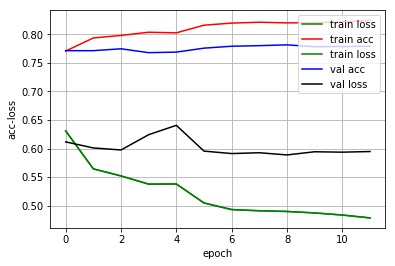

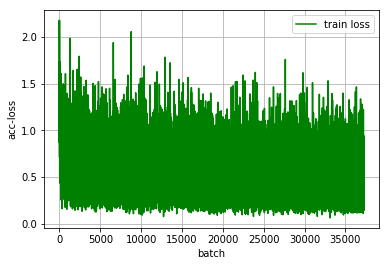

In [15]:
import matplotlib.pyplot as plt
import pickle
to_save={}
to_save['losses']=ensemble_history.losses
to_save['accuracy']=ensemble_history.accuracy
to_save['val_loss']=ensemble_history.val_loss
to_save['val_acc']=ensemble_history.val_acc
with open('ensemble_history.pickle','wb') as f:
    pickle.dump(to_save,f)
ensemble_history.loss_plot('epoch')
ensemble_history.loss_plot('batch')
plt.show()

# 采用bagging的方法

In [22]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

In [7]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=16
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


In [2]:
#载入自己的模型
my_model=load_model('./mymodel.h5')

In [3]:
#载入训练好的inceptionv3
inception_model=load_model('./inception.h5')

In [4]:
#载入训练好的resnet-50
resnet_model=load_model('./resnet.h5')

In [8]:
mapdict=train_generator.class_indices
mapdict={v: k for k, v in mapdict.items()}

In [9]:
print(mapdict)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [19]:
rootdir = './test/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not file.endswith(".jpeg"):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))

In [45]:
print(test_laels[0],test_images[0])

2 ./test/2/enhance_0_6030.jpeg


In [48]:
predict=[]
length=len(test_images)
for i in range((length//64)+1):
    inputimg=test_images[64*i:64*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    # my_model预测出结果
    my_model_batch=my_model.predict(np.array(test_batch))
    #64*5，predict就是直接返回当前模型的预测结构，是个五维度向量，一共六十四个
    my_model_batch=list(np.argmax(my_model_batch,axis=1))
    my_model_batch=[mapdict[con] for con in my_model_batch]
#     print(my_model_batch)
    #inceptionv3预测出结果
    inception_model_batch=inception_model.predict(np.array(test_batch))
    inception_model_batch=list(np.argmax(inception_model_batch,axis=1))
    inception_model_batch=[mapdict[con] for con in inception_model_batch]
#     print(inception_model_batch)
    #resnet预测出的结果
    resnet_model_batch=resnet_model.predict(np.array(test_batch))
    resnet_model_batch=list(np.argmax(resnet_model_batch,axis=1))
    resnet_model_batch=[mapdict[con] for con in resnet_model_batch]
#     print(resnet_model_batch)
    #接下来将三个预测的结果bagging
    predict_batch=[]
    for i,j,k in zip(my_model_batch,inception_model_batch,resnet_model_batch):
        count=defaultdict(int)
        count[i]+=1
        count[j]+=1
        count[k]+=1
        #将预测结果降序排列# 出现的结果按个数排序
        predict_one=sorted(count.items(), key=operator.itemgetter(1),reverse=True)[0][0]
        predict_batch.append(predict_one)
#     print('predict:',predict_batch)
    predict.append(predict_batch)

In [42]:
predict=sum(predict,[]) 
# 是列表，predict，求和列表；多维度转换一维度列表。

In [43]:
# print(predict)

['1', '1', '2', '2', '2', '0', '0', '2', '1', '2', '1', '2', '2', '2', '2', '2', '2', '0', '2', '2', '3', '0', '2', '2', '0', '0', '2', '0', '2', '1', '3', '2', '3', '2', '1', '0', '2', '2', '1', '2', '0', '2', '4', '2', '2', '1', '2', '0', '2', '3', '2', '2', '3', '3', '0', '1', '2', '0', '1', '2', '0', '2', '1', '2', '0', '0', '2', '2', '1', '2', '4', '2', '2', '2', '2', '0', '0', '2', '1', '1', '0', '2', '2', '1', '1', '2', '1', '1', '2', '2', '0', '0', '0', '3', '2', '1', '2', '2', '0', '2', '2', '2', '0', '1', '1', '0', '1', '2', '0', '2', '2', '2', '2', '0', '1', '1', '2', '0', '2', '0', '4', '2', '2', '2', '0', '2', '2', '2', '2', '2', '0', '0', '4', '0', '3', '2', '1', '2', '2', '1', '0', '0', '0', '2', '0', '2', '0', '2', '1', '2', '2', '1', '1', '2', '4', '2', '0', '2', '2', '1', '0', '0', '2', '2', '0', '2', '0', '0', '1', '1', '1', '0', '1', '3', '0', '0', '3', '2', '0', '2', '2', '2', '2', '0', '2', '0', '3', '0', '0', '1', '2', '0', '1', '2', '2', '2', '1', '2', '2', '2',

In [44]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(test_laels,predict)
print('bagging的准确率是:%s'%acc)

bagging的准确率是:0.7448


# 采用Add将各个模型的最后一层输出相加

In [52]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout,Add
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

In [53]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=16
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


In [54]:
#载入自己的模型
my_model=load_model('./mymodel.h5')
#载入训练好的inceptionv3
inception_model=load_model('./inception.h5')
#载入训练好的resnet-50
resnet_model=load_model('./resnet.h5')

In [62]:
mapdict=train_generator.class_indices
mapdict={v: k for k, v in mapdict.items()}

In [61]:
img=Input(shape=(512,512,3),name='img')
feature1=my_model(img)
feature2=inception_model(img)
feature3=resnet_model(img)
for layer in my_model.layers:  
    layer.trainable = False 
for layer in inception_model.layers:  
    layer.trainable = False  
for layer in resnet_model.layers:  
    layer.trainable = False 
output=Add()([feature1,feature2,feature3])
#feature都是五维度

model=Model(inputs=img,outputs=output)
plot_model(model=model,to_file='./Add.jpg')
#定义一下优化的方法
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [56]:
rootdir = './test/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not file.endswith(".jpeg"):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))

In [58]:
predict=[]
length=len(test_images)
for i in range((length//64)+1):
    inputimg=test_images[64*i:64*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    # my_model预测出结果  三个的
    model_batch=model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(model_batch,axis=1))
    predict_batch=[mapdict[con] for con in predict_batch]
    predict.append(predict_batch)

In [59]:
predict=sum(predict,[])

In [60]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(test_laels,predict)
print('Add的准确率是:%s'%acc)

Add的准确率是:0.7571
